In [2]:
## !pip install tensorflow tensorflow-datasets


##1. Importações

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


##2. Carregamento do Dataset: Cats vs Dogs

In [3]:
(train_data, validation_data), dataset_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.P1P019_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


##3. Pré-processamento dos Dados

In [4]:
IMG_SIZE = 160
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = (train_data
                 .map(format_image)
                 .shuffle(SHUFFLE_BUFFER_SIZE)
                 .batch(BATCH_SIZE))

validation_batches = (validation_data
                      .map(format_image)
                      .batch(BATCH_SIZE))


##4. Carregar o Modelo Pré-Treinado (Transfer Learning)

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Congela o modelo base


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


##5. Construir o Modelo Final

In [6]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binário: gato vs cachorro
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

##6. Treinar o Modelo

In [7]:
EPOCHS = 5
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 499s 844ms/step - accuracy: 0.9458 - loss: 0.1413 - val_accuracy: 0.9822 - val_loss: 0.0506
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 518s 885ms/step - accuracy: 0.9836 - loss: 0.0445 - val_accuracy: 0.9839 - val_loss: 0.0439
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 534s 839ms/step - accuracy: 0.9854 - loss: 0.0404 - val_accuracy: 0.9834 - val_loss: 0.0441
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 531s 908ms/step - accuracy: 0.9891 - loss: 0.0348 - val_accuracy: 0.9837 - val_loss: 0.0437
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 493s 844ms/step - accuracy: 0.9886 - loss: 0.0320 - val_accuracy: 0.9832 - val_loss: 0.0476


##7. Avaliar e Plotar os Resultados

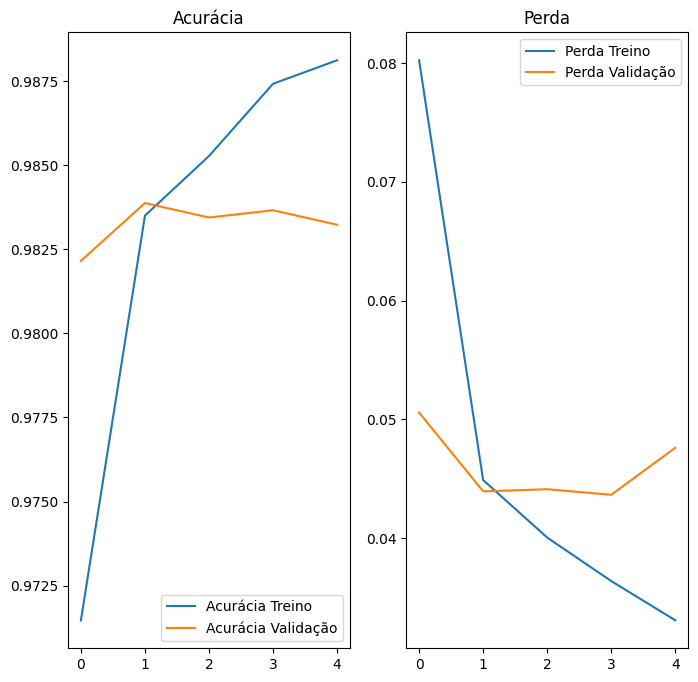

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia Treino')
plt.plot(epochs_range, val_acc, label='Acurácia Validação')
plt.legend(loc='lower right')
plt.title('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda Treino')
plt.plot(epochs_range, val_loss, label='Perda Validação')
plt.legend(loc='upper right')
plt.title('Perda')
plt.show()
